In [1]:
import numpy as np
from astropy.io import fits
import datetime 
import matplotlib.pyplot as plt
import sys
sys.path.append('../radiospectra2')
from radiospectra.sources import CallistoSpectrogram 
from Orfees_read import *
from scipy import signal
from datetime import timedelta
from matplotlib.ticker import ScalarFormatter, MaxNLocator

the Orfees methods are imported....


In [2]:
import pandas as pd


def range_pix(orfees, spce):

    min_freq = spce.freq_axis.min()
    max_freq = spce.freq_axis.max()
    mask = (orfees.freq_axis > min_freq) & (orfees.freq_axis < max_freq)
    range_freq = orfees.freq_axis[mask]
    range_pixels = orfees.data[mask, :]

    return range_pixels, min_freq, max_freq, range_freq



def get_date_from_spec(spec):
    obs_start = spec.header['DATE-OBS'] 
    time_start = spec.header['TIME-OBS']
    time_end = spec.header['TIME-END']
    obs_end = spec.header['DATE-END'] 
    delta_time = spec.header['CDELT1'] 

    start_time = datetime.datetime.strptime(obs_start + " " + time_start, "%Y/%m/%d %H:%M:%S.%f")
    end_time = datetime.datetime.strptime(obs_end + " " + time_end, "%Y/%m/%d %H:%M:%S")
    date_list = []

    while start_time < end_time:
        date_list.append(start_time)
        start_time += timedelta(seconds=delta_time)

    return date_list


def intensity_to_db(df, factor=0.0386):
    return 10 ** (df * factor)


def get_sub_plots(orfees, spec):
    orfees_dates = list(orfees.convert_ms_to_date())
    orfees_dates.sort()
    spec_dates = get_date_from_spec(spec)

    _data, min_freq, max_freq, _range = range_pix(orfees, spec)
    filtered_data = signal.medfilt2d(_data, 3)


    spec_df = pd.DataFrame(spec.data)

    ecallisto_data_db = intensity_to_db(pd.DataFrame(spec_df))
    scaled_ecallisto_data_db = ecallisto_data_db 



    orfees_min = min(_range)
    orfees_max = max(_range)

    ymin = min(spec.freq_axis)
    ymax = max(spec.freq_axis)

    plt.rcParams["figure.autolayout"] = True
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for row in axs:
        for ax in row:
            ax.xaxis.set_major_locator(MaxNLocator(prune='lower', nbins=8))

    for ax in axs[0]:
        ax.set_xticklabels(orfees_dates[::int(len(orfees_dates)//6)], rotation=50, horizontalalignment="right")

    for ax in axs[1]:
        tick_labels = [date.strftime('%H:%M:%S') for date in spec_dates[::int(len(spec_dates)//7)]]
        ax.set_xticklabels(tick_labels, rotation=50, horizontalalignment="right")

    axs[0, 0].imshow(filtered_data, vmin=np.nanmin(filtered_data), vmax=1000, aspect="auto")
    axs[0, 0].set_title("ORFEES")
    axs[0, 0].set_xlabel('Time [UT]')
    axs[0, 0].set_ylabel('Frequency [MHz]')
    axs[0, 0].set_ylim(orfees_max, orfees_min)

    axs[1, 0].imshow(spec.data[::-1], aspect="auto", extent=[-1, spec.shape[1], ymax, ymin])
    axs[1, 0].set_title("eCallisto_BIR")
    axs[1, 0].set_xlabel('Time [UT]')
    axs[1, 0].set_ylabel('Frequency [MHz]')
    
    axs[0, 1].plot(np.nansum(filtered_data, axis=0))
    axs[0, 1].set_ylabel('Intensity [sfu]')
    axs[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    axs[1, 1].plot(np.nansum(scaled_ecallisto_data_db, axis=0))
    axs[1, 1].set_ylabel('Intensity')
    axs[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # axs[0, 1].plot(np.nansum(filtered_data, axis=0))
    # axs[0, 1].set_ylabel('Intensity [sfu]')
    # 
    # axs[1, 1].plot(np.nansum(scaled_ecallisto_data_db, axis=0))
    # axs[1, 1].set_ylabel('Intensity')

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1494646/1228185141.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(orfees_dates[::int(len(orfees_dates)//6)], rotation=50, horizontalalignment="right")
/tmp/ipykernel_1494646/1228185141.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels, rotation=50, horizontalalignment="right")


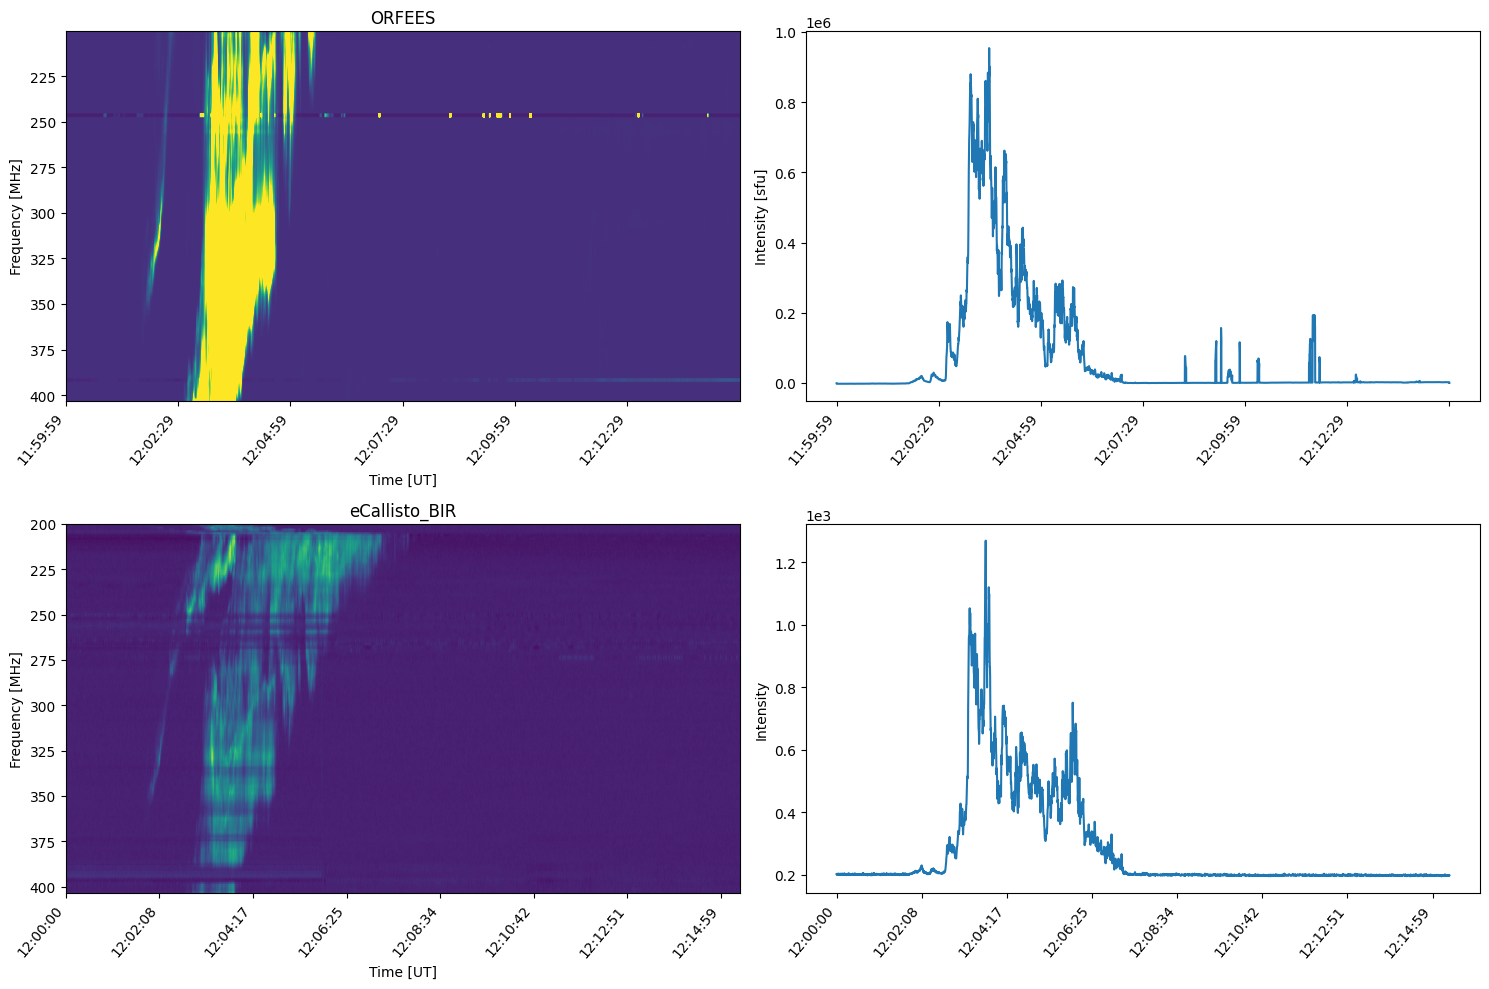

In [3]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
orfees_sb = orfees.subtract_bg()
spec = CallistoSpectrogram.read("eca_files/BIR_20151104_120000_03 (1).fit.gz")
spec_sb=spec.subtract_bg()

get_sub_plots(orfees_sb, spec_sb)